In [4]:
import sys
import os

# Adiciona o diretório base ao sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Ajuste conforme a localização do notebook
if project_path not in sys.path:
    sys.path.insert(0, project_path)

    from modules.plot_solutions import plot_solutions
from modules.nsga2 import nsga2_func
from modules.nsga3 import nsga3_func
from modules.nsga3_deap import nsga3_deap_func
from modules.nsga3_pymoo import nsga3_pymoo_func

In [5]:
def func1_2d(x):
    return x[0]**2

def func2_2d(x):
    return (x[0] - 2)**2

In [6]:
bounds_2d = [(-5, 5)]
functions_2d = [func1_2d, func2_2d]
NUM_GEN = 16
POP_SIZE = 52

In [7]:
import random
import numpy as np

Vector = np.ndarray
Bounds = list[tuple[float, float]]

# Hiperparâmetros (ajuste se quiser, mantendo as assinaturas)
_ETA_C = 20.0   # distribution index do SBX (tipicamente 10–30)
_ETA_M = 25.0   # distribution index da mutation (tipicamente 10–50)
_MUTATION_RATE = 0.5  # prob. de mutar o indivíduo (mantida a lógica original)

def crossover(parent1: Vector, parent2: Vector) -> tuple[Vector, Vector]:
    """
    SBX (Deb & Agrawal, 1995). Opera componente a componente.
    """
    n = parent1.shape[0]
    c1 = np.empty_like(parent1)
    c2 = np.empty_like(parent2)

    for i in range(n):
        x1 = parent1[i]
        x2 = parent2[i]

        if random.random() < 0.5 and abs(x1 - x2) > 1e-14:
            if x1 > x2:
                x1, x2 = x2, x1  # garantir x1 <= x2

            u = random.random()
            beta = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1 + 1e-14))  # limites desconhecidos aqui; não usados
            # Fórmula padrão sem limites explícitos:
            if u <= 0.5:
                beta_q = (2.0 * u) ** (1.0 / (_ETA_C + 1.0))
            else:
                beta_q = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (_ETA_C + 1.0))

            c1[i] = 0.5 * ((x1 + x2) - beta_q * (x2 - x1))
            c2[i] = 0.5 * ((x1 + x2) + beta_q * (x2 - x1))
        else:
            # sem recombinação (ou genes idênticos): copiar
            c1[i] = x1
            c2[i] = x2

    return (c1, c2)


def mutation(individual: Vector, bounds: Bounds) -> Vector:
    """
    Polynomial mutation (Deb, 2001). Aplica por gene com prob ~ 1/n.
    Mantém a mesma probabilidade global de mutação do código original (_MUTATION_RATE).
    """
    n = individual.shape[0]
    pm = 1.0 / n  # probabilidade por variável (prática comum)

    if random.random() < _MUTATION_RATE:
        y = individual.copy()
        for i in range(n):
            if random.random() < pm:
                yl, yu = bounds[i]
                if yu <= yl:  # proteção
                    continue
                y_i = y[i]
                # Normalizar para [0,1] dentro dos limites
                delta1 = (y_i - yl) / (yu - yl)
                delta2 = (yu - y_i) / (yu - yl)
                r = random.random()

                mut_pow = 1.0 / (_ETA_M + 1.0)
                if r < 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * r + (1.0 - 2.0 * r) * (xy ** (_ETA_M + 1.0))
                    deltaq = (val ** mut_pow) - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - r) + 2.0 * (r - 0.5) * (xy ** (_ETA_M + 1.0))
                    deltaq = 1.0 - (val ** mut_pow)

                y[i] = y_i + deltaq * (yu - yl)
                # Garantir limites
                y[i] = np.clip(y[i], yl, yu)
        return y

    return individual


In [8]:
import random
import numpy as np

initial_population = [
            np.array([random.uniform(b[0], b[1]) for b in bounds_2d])
            for _ in range(POP_SIZE)
        ]

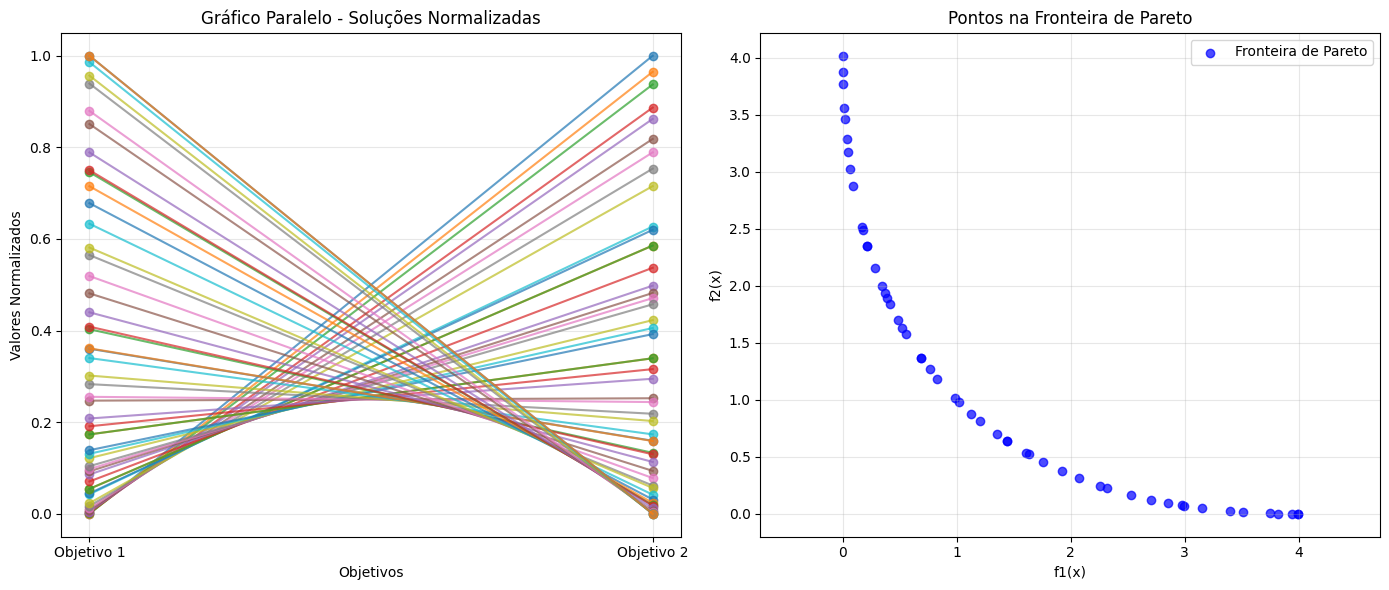

In [9]:
pareto_front_my_nsga2 = nsga2_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    crossover, 
    mutation,
    initial_population)

plot_solutions(pareto_front_my_nsga2)

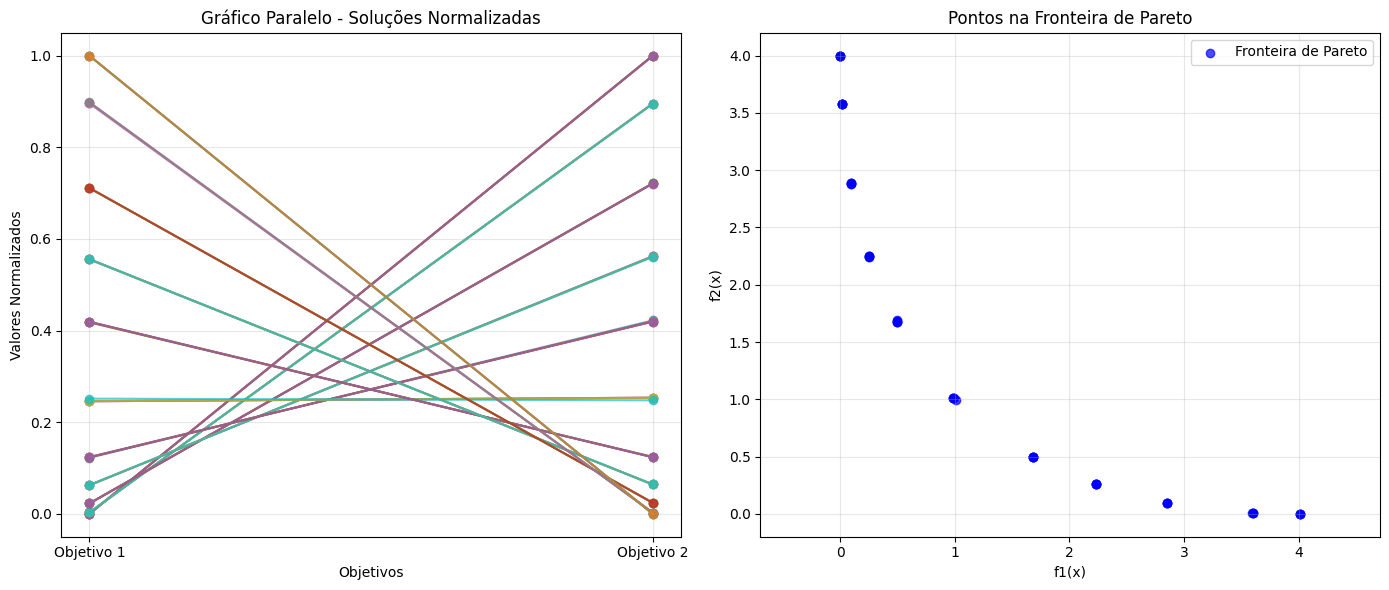

In [10]:
pareto_front_my_nsga3 = nsga3_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    crossover, 
    mutation,
    initial_population)

plot_solutions(pareto_front_my_nsga3)

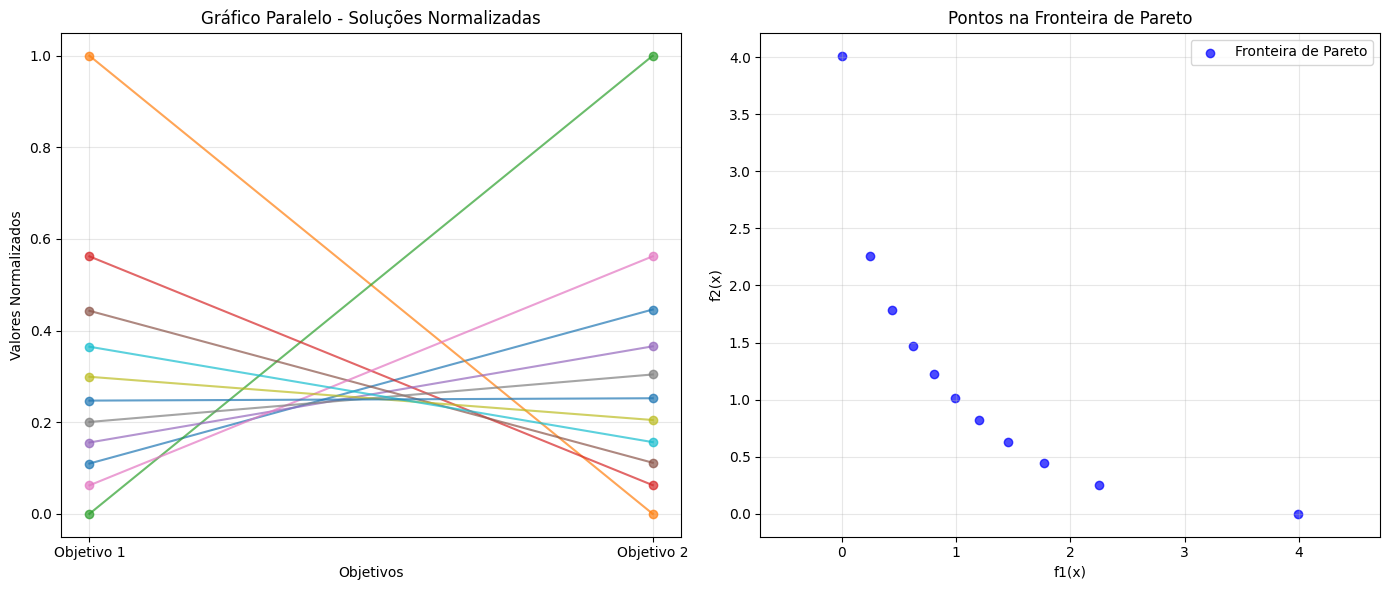

In [13]:
pareto_front_pymoo_nsga3 = nsga3_pymoo_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    crossover, 
    mutation,
    initial_population)

plot_solutions(pareto_front_pymoo_nsga3)

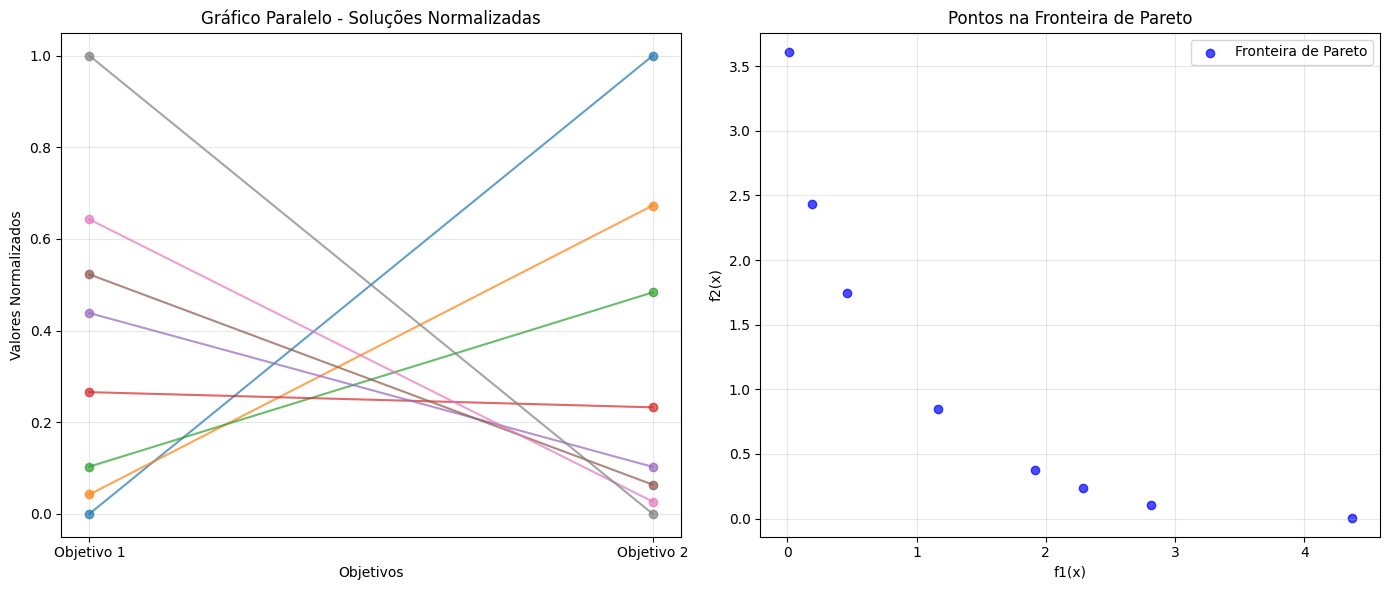

In [12]:
pareto_front_deap_nsga3 = nsga3_deap_func(
    POP_SIZE, 
    NUM_GEN, 
    bounds_2d, 
    functions_2d, 
    crossover, 
    mutation,
    initial_population)

plot_solutions(pareto_front_deap_nsga3)